# Cell 1: Install & Import Necessary Libraries

In [3]:
# Install necessary libraries if not already installed
!pip install spacy xgboost

# Import libraries
import os
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Cell 2: Load the Dataset

In [5]:
# Load the resume.csv file
df = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Display the first few rows
df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Data & Basic Info

In [6]:
# Check for missing values
print(df.isnull().sum())

# Display dataset information
df.info()

# Drop rows with missing values (if any)
df.dropna(inplace=True)


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


# Cell 4: Advanced Text Preprocessing Function

In [8]:
def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 2. Convert to lowercase
    text = text.lower()
    
    # 3. Remove extra whitespace and special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only letters
    
    # 4. Tokenization and Lemmatization using SpaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 1]
    
    # 5. Remove short words (less than 3 characters) and join
    cleaned_text = ' '.join([word for word in tokens if len(word) > 2])
    
    return cleaned_text

# Apply preprocessing to 'resume_str'
df['clean_resume'] = df['Resume_str'].apply(clean_text)

# Display sample cleaned text
df[['Resume_str', 'clean_resume']].head()


,Resume_str,clean_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,administrator marketing associate administrato...
1,"HR SPECIALIST, US HR OPERATIONS ...",specialist operation summary versatile medium ...
2,HR DIRECTOR Summary Over 2...,director summary year experience recruit ...
3,HR SPECIALIST Summary Dedica...,specialist summary dedicate drive dynamic ...
4,HR MANAGER Skill Highlights ...,manager skill highlight skill department start...


# Cell 5: Data Visualization (Optional)

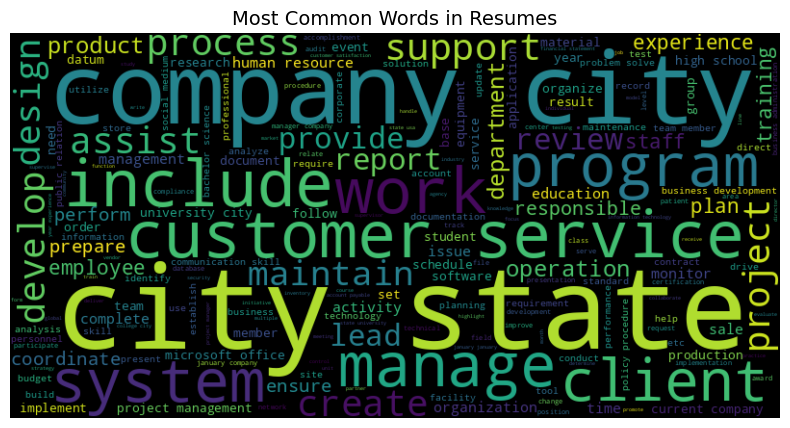

In [9]:
# Generate a WordCloud to visualize frequent words
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['clean_resume']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Resumes", fontsize=14)
plt.show()


# Cell 6: Convert Categories to Numeric Labels

In [11]:
# Encode categories into numeric labels
label_encoder = LabelEncoder()
df['Category_label'] = label_encoder.fit_transform(df['Category'])

# Display mapping of labels
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


{'ACCOUNTANT': 0,
 'ADVOCATE': 1,
 'AGRICULTURE': 2,
 'APPAREL': 3,
 'ARTS': 4,
 'AUTOMOBILE': 5,
 'AVIATION': 6,
 'BANKING': 7,
 'BPO': 8,
 'BUSINESS-DEVELOPMENT': 9,
 'CHEF': 10,
 'CONSTRUCTION': 11,
 'CONSULTANT': 12,
 'DESIGNER': 13,
 'DIGITAL-MEDIA': 14,
 'ENGINEERING': 15,
 'FINANCE': 16,
 'FITNESS': 17,
 'HEALTHCARE': 18,
 'HR': 19,
 'INFORMATION-TECHNOLOGY': 20,
 'PUBLIC-RELATIONS': 21,
 'SALES': 22,
 'TEACHER': 23}

# Cell 7: Train-Test Split

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_resume'], df['Category_label'], test_size=0.2, random_state=42, stratify=df['Category_label'])

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1987, Testing samples: 497


# Cell 8: Feature Extraction with TF-IDF

In [15]:
# Convert text into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Transform train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print shape of transformed data
print(f"TF-IDF Train Shape: {X_train_tfidf.shape}, TF-IDF Test Shape: {X_test_tfidf.shape}")


TF-IDF Train Shape: (1987, 5000), TF-IDF Test Shape: (497, 5000)


# Cell 9: Train XGBoost Model

In [16]:
# Initialize XGBoost classifier with optimized hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=len(df['Category_label'].unique()),
    learning_rate=0.1, 
    n_estimators=300, 
    max_depth=8, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Train the model
xgb_model.fit(X_train_tfidf, y_train)

# Predictions on test set
y_pred = xgb_model.predict(X_test_tfidf)


# Cell 10: Evaluate the Model

Accuracy: 0.7847
Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.85      0.96      0.90        24
              ADVOCATE       0.80      0.83      0.82        24
           AGRICULTURE       1.00      0.46      0.63        13
               APPAREL       0.70      0.37      0.48        19
                  ARTS       0.56      0.48      0.51        21
            AUTOMOBILE       0.50      0.29      0.36         7
              AVIATION       0.91      0.83      0.87        24
               BANKING       0.80      0.70      0.74        23
                   BPO       1.00      0.25      0.40         4
  BUSINESS-DEVELOPMENT       0.77      0.96      0.85        24
                  CHEF       0.91      0.83      0.87        24
          CONSTRUCTION       0.90      0.86      0.88        22
            CONSULTANT       0.70      0.61      0.65        23
              DESIGNER       0.83      0.90      0.86        2

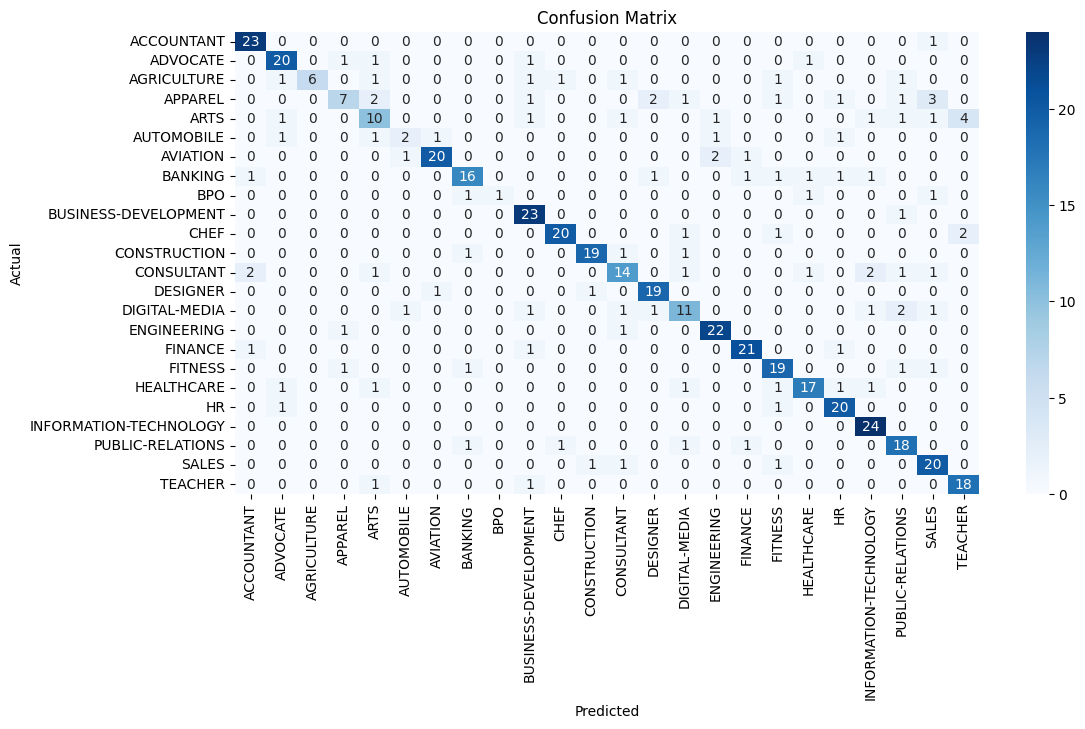

In [17]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Cell 11: Precision, Recall, F1-score

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.7864
Recall: 0.7847
F1 Score: 0.7753
